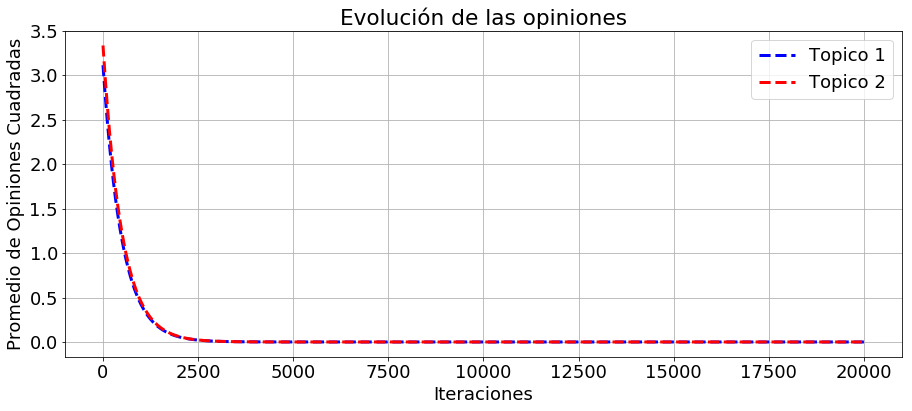

Esto tardó 2.2301275730133057 segundos


In [36]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################
# Acordate que en casa los ldata tienen que empezar con Tests/
# En la facultad va directo el nombre del archivo
############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda. Al darle la dirección de la carpeta Datos, lo que estoy sacando
# son los nombres de todos los archivos en esa carpeta.
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos")]

##############################################################################
# Los primero dos elementos de CarpCheck no les des bola, porque son
# la mismísma carpeta en la que estás y porque el segundo es ipynb checkpoints
# Eso es algo del notebook, no del TP.
##############################################################################

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[1] es el nombre de la carpeta


for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Leo mi archivo

Datos = ldata("{}/{}".format(Archivos_Datos[0],Archivos_Datos[1]))

# Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
# archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

N = int(Archivos_Datos[1].split("_")[3].split("=")[1])
T = int(Archivos_Datos[1].split("_")[4].split("=")[1])
K = float(Archivos_Datos[1].split("_")[5].split("=")[1])

# Hagamos un gráfico de estos datos. Por lo menos del caso K=0
# Quiero hacer un gráfico en el que se vea que las opiniones van cayendo a cero.
# La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.

# Primero me armo una lista que tenga todos los valores que están en Datos sin ese
# espacio que está en la primer coordenada. También estaría bueno pasar los strings
# a floats.

Opiniones = []
for fila in Datos[5:len(Datos)]:
    # Arranco desde 5 porque las primeras son títulos y las matrices de Adyacencia y Superposicion
    fila2 = [float(x) for x in fila[1:len(fila)]]
    Opiniones.append(fila2)
    # Debería haber una forma más compacta de hacer esto. Quizás podría hacer una función de esto.
    # La otra es meter un espacio en los títulos también, para al levantar datos eliminar
    # eso de una también. Y luego el mismo Datos que tenga todos los números y listo.

# Me armo los vectores X e Y que voy a graficar
X = np.arange(0,len(Opiniones))
Y1 = []
Y2 = []
for i in range(len(Opiniones)):
    # Obtengo los valores cuadrados de todos los tópicos
    T0 = [t**2 for t in Opiniones[i][0:len(Opiniones[i]):T]]
    T1 = [t**2 for t in Opiniones[i][1:len(Opiniones[i]):T]]
    # Ahora los sumo y los agrego a mis vectores Y
    Y1.append(np.sum(T0)/len(T0))
    Y2.append(np.sum(T1)/len(T1))

    
plt.figure(figsize=(15,6))
plt.plot(X,Y1, "--b",label="Topico 1" ,linewidth = 3)
plt.plot(X,Y2, "--r",label="Topico 2" ,linewidth = 3)
plt.rcParams.update({'font.size': 18})
plt.xlabel("Iteraciones")
plt.ylabel("Promedio de Opiniones Cuadradas")
plt.title("Evolución de las opiniones")
plt.legend()
plt.grid()
plt.show()





Tiempo()

Esto tardó 0.004000186920166016 segundos
